# Mini Proyecto 3
## Page Rank
- Ortega Ibarra Jaime Jesus

Usando el algoritmo de Page Rank y la base de datos que se te fue asignada, calcula la relevancia de los nodos a partir de la relevancia de los enlaces entrantes.

La red se recopiló rastreando el sitio web de Amazon. Se basa en la función Clientes que compraron este artículo también compraron del sitio web de Amazon. Si un producto $i$ se compra con frecuencia junto con el producto $j$ , la gráfica contiene un borde dirigido de $i$ a $j$ .

## Librerías

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix
from scipy import sparse
import matplotlib.pyplot as plt

## Datos

Mediante la ayuda de $Pandas$ realizamos la lectura de nuestros datos para poder explorar, debido a la estructura de los datos utilizamos $sep=t$ y nos brincamos las primeras filas.

In [2]:
data = pd.read_csv('amazon0302.txt', sep="\t", skiprows=3)
data.head()

,# FromNodeId,ToNodeId
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


Como exploración calculamos el total de los datos, pues eso nos dará el número total de aristas.

In [3]:
len(data)

1234877

In [4]:
len(set(data['# FromNodeId']))

257570

In [5]:
len(set(data['ToNodeId']))

262111

In [6]:
len(set(data['ToNodeId'])) - len(set(data['# FromNodeId']))

4541

Visualizamos los productos mas redirigidos por otros y aquellos que redirigen a otros

In [7]:
freq = data['ToNodeId'].value_counts()
freq[0:10]

14949    420
4429     404
33       361
10519    334
12771    330
8        293
297      280
481      275
5737     272
9106     227
Name: ToNodeId, dtype: int64

In [8]:
nodes_frec = ['14949', '4429', '33', '10519', '12771', '8', '297', '481', '5737', '9106']
frec = [420, 404, 361, 334, 330, 293, 280, 275, 272, 227]
color = ['indianred','darkcyan','steelblue','slategray',
        'skyblue', 'silver', 'teal', 'salmon',
        'royalblue', 'tan']

Visualizamos mediante una gráfica de barras.

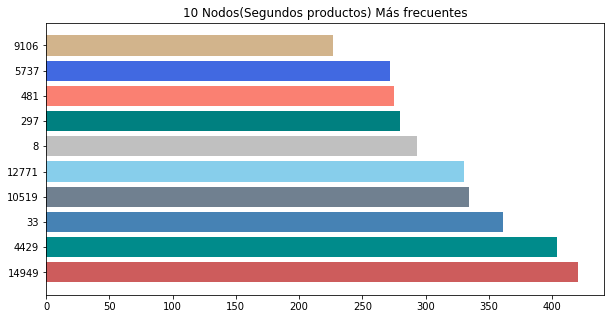

In [9]:
plt.figure(figsize=(10,5))
for i in range(len(frec)):
    plt.barh(nodes_frec[i], frec[i], color=color[i])
plt.title('10 Nodos(Segundos productos) Más frecuentes')
plt.yticks(range(len(frec)), nodes_frec)
plt.show()

Mediante la función $value_counts()$ podemos obtener los nodos mas frecuentes como nodo inical.

In [10]:
freq = data['# FromNodeId'].value_counts()
freq[0:10]

2047     5
14690    5
22894    5
16749    5
18796    5
29035    5
31082    5
24937    5
26984    5
4455     5
Name: # FromNodeId, dtype: int64

In [11]:
nodes_frec = ['2047', '14690', '22894', '16749', '18796', '29035', '31082', '24937', '26984', '4455']
frec = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
color = ['indianred','darkcyan','steelblue','slategray',
        'skyblue', 'silver', 'teal', 'salmon',
        'royalblue', 'tan']

Visualizamos mediante una gráfica de barras.

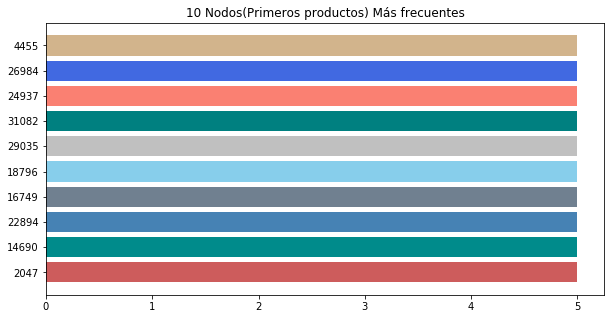

In [12]:
plt.figure(figsize=(10,5))
for i in range(len(frec)):
    plt.barh(nodes_frec[i], frec[i], color=color[i])
plt.title('10 Nodos(Primeros productos) Más frecuentes')
plt.yticks(range(len(frec)), nodes_frec)
plt.show()

Mediante la función $set()$ obtenemos nuestros nodos, en este caso nos basamos en $ToNodeId$, ya que hay nodos que no dirigen a otros, por lo que dentro de $\#FromNode$ no aparecen.

In [13]:
nodos = len(set(data['ToNodeId']))

Con ayuda de $Networkx$ podemos crear nuestro grafo, esto nos facilitará poder obtener la cantidad de aristas de cada uno y así poder obtener nuestra matriz, a continuación creamos las tuplas de las aristas para crear el grafo con la función $add\_edges\_from()$

In [14]:
conjunto = data[['# FromNodeId', 'ToNodeId']]
tuplas = [tuple(x) for x in conjunto.values]

In [15]:
G = nx.DiGraph()
G.add_edges_from(tuplas)

Mediante $draw()$ podemos dibujar nuestro grafo (No lo intente, tarda mucho).

In [16]:
#nx.draw(G, with_labels=True)
#plt.plot()

Mediante la función $neighbors$, podemos obtener los nodos a los cuales apunta nuestro nodo inicial, de esta manera sabemos a cuantos nodos apunta, dado que esta función devuelve una lista, obtenemos la cantidad mediante $len()$

In [17]:
longitudes_vecinos = []
for i in list(set(data['ToNodeId'])):
    longitudes_vecinos.append(len([n for n in G.neighbors(i)]))

In [18]:
len(longitudes_vecinos)

262111

### Matriz

Creamos una matriz de dimensión $n\times n$ donde $n=Numero\_nodos$

In [19]:
nodos = list(set(data['ToNodeId']))
longitud = len(nodos)

Me he apoyado de la función $sparse()$ y $tolil$, pues al utilziar $Numpy$, por ser una matriz de dimensiónes tan grandes, era imposible.

In [20]:
Matriz = sparse.bsr_matrix((longitud,longitud))
Matriz_lil = Matriz.tolil()

Obtenemos los valores de la matriz, dado que los nodos son valores enteros, podemos ver estos como una posición, por lo que inicialmente obtenemos los vecinos de cada uno de estos nodos, posterior a ello, almacenamos en nuestra matriz de acuerdo a las posiciones anteriormente mencionadas el valor $1/cantidad\_vecinos$, siempre y cuando dicha cantidad sea mayor a $0$, pues en caso conmtrario únicamente se almacenará un $0$

In [21]:
for nodo in set(data['ToNodeId']):
    vecinos_nodos = list(G.neighbors(nodo))
    if len(vecinos_nodos) == 0:  
        for nodo_incial in list(G.neighbors(nodo)):
            Matriz_lil[nodo_incial,nodo] = 0
    else:
        for nodo_incial in list(G.neighbors(nodo)):
            Matriz_lil[nodo_incial,nodo] = 1/len(vecinos_nodos)

In [22]:
Matriz_lil.shape[0]

262111

### PageRank
Basandome en el algoritmo visto en clase, de la siguiente manera podemos calcular utilizando el $Page Rank$ con callejones sin salida, pues como recordamos, tenemos nodos que no apuntan a otros nodos, por lo que no tenemos salida.

Utilicé una $\beta = 0.8$ 

Calculamos nuestra primer iteración, almacenandola en una lista mediante $np.ones()$

In [23]:
nodes = Matriz_lil.shape[0]
iteraciones = np.ones(nodes) / nodes

Creamos un ciclo de acuerdo a la cantidad de iteraciones necesarias, realizando las operaciónes entre la Matriz dispersa y nuestra $\beta$ asignada para ir calculando la cantidad de iteraciones necesarias.

In [24]:
for i in range(15):
    print('Iteración ',i,':')
    print(iteraciones,'\n')
    r_temp = 0.8 * Matriz_lil @ iteraciones
    iteraciones = r_temp + ((1 - r_temp.sum()) / nodes)

Iteración  0 :
[3.81517754e-06 3.81517754e-06 3.81517754e-06 ... 3.81517754e-06
 3.81517754e-06 3.81517754e-06] 

Iteración  1 :
[2.03676983e-06 1.42634142e-06 2.03676983e-06 ... 1.42634142e-06
 1.42634142e-06 1.42634142e-06] 

Iteración  2 :
[1.35704561e-06 1.12883098e-06 1.35704561e-06 ... 1.81251079e-06
 1.03116243e-06 1.22649952e-06] 

Iteración  3 :
[1.19825989e-06 1.01764693e-06 1.19825989e-06 ... 1.78893723e-06
 1.09052136e-06 1.17917701e-06] 

Iteración  4 :
[1.15438306e-06 9.91559552e-07 1.15438306e-06 ... 1.81919623e-06
 1.08606793e-06 1.18221046e-06] 

Iteración  5 :
[1.14285596e-06 9.84206434e-07 1.14285596e-06 ... 1.83450982e-06
 1.09057654e-06 1.18705920e-06] 

Iteración  6 :
[1.13969641e-06 9.82223384e-07 1.13969641e-06 ... 1.84497224e-06
 1.09288800e-06 1.19067612e-06] 

Iteración  7 :
[1.13877907e-06 9.81623333e-07 1.13877907e-06 ... 1.85129823e-06
 1.09446747e-06 1.19307633e-06] 

Iteración  8 :
[1.13847058e-06 9.81410851e-07 1.13847058e-06 ... 1.85559568e-06
 1.09541

In [25]:
print(iteraciones)

[1.13803174e-06 9.81058687e-07 1.13803174e-06 ... 1.86520995e-06
 1.09732293e-06 1.19752721e-06]


In [26]:
sum(iteraciones)

0.9999999999999895

He decidido dejar 15 iteraciones, pues converge muy rápido